In [1]:
from Bio import Phylo 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import phylovelo as pv
import scanpy as sc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import anndata as ad
from scipy.stats import mannwhitneyu
import seaborn as sns

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams['font.size'] = 12

In [4]:
count = pd.read_csv('/data3/xiangwei/jobs/tcr_lineage/BCC/bcc_scRNA_counts.txt', index_col=0, sep='\t').T

In [6]:
import re
drop_genes = []
for i in count.columns:
    for num in re.finditer('[0-9]+', i):
        if len(num.group(0)) > 4:
            drop_genes.append(i)
            continue
count = count[count.columns[~np.isin(count.columns, drop_genes)]]

In [7]:
metadata = pd.read_csv('/data3/wangkun/phylovelo_datasets/tcr/clonesizeToWangkun.csv', index_col=0)

In [8]:
sel_cells = metadata[(metadata.patient=='su009').to_numpy() & (~np.isin(metadata.cluster, ['Tfh', 'Th17', 'Tregs']))].index

In [66]:
sd = pv.scData(count=count.loc[sel_cells], Xdr=metadata.loc[sel_cells][['UMAP1', 'UMAP2']])

In [67]:
sd.drop_duplicate_genes()
sd.normalize_filter()
sd.cell_states = metadata.loc[sel_cells]['cluster'].to_numpy()

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/data_struct.py:114: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.x_normed = np.divide(self.count, counts_per_cell[:, None])


In [468]:
clonesize = metadata.loc[sel_cells].clonesizeInCase.to_numpy()

In [69]:
pv.velocity_inference(sd, np.round(np.log(clonesize)), cutoff=0.97, target='x_normed')
pv.velocity_embedding(sd, target='x_normed', n_neigh=500)

  0%|          | 0/12252 [00:00<?, ?it/s]

  0%|          | 0/4659 [00:00<?, ?it/s]

In [71]:
sel_cells = metadata[~np.isin(metadata.cluster, ['Tfh', 'Th17', 'Tregs'])].index

In [72]:
sd_full = pv.scData(count=count.loc[sel_cells], Xdr=metadata.loc[sel_cells][['UMAP1', 'UMAP2']])

In [73]:
sd_full.drop_duplicate_genes()
sd_full.normalize_filter()
sd_full.cell_states = metadata.loc[sel_cells]['cluster'].to_numpy()

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/data_struct.py:114: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.x_normed = np.divide(self.count, counts_per_cell[:, None])


In [75]:
sd_full.x_normed = sd_full.x_normed[sd.x_normed.columns]

In [76]:
sd_full.velocity = sd.velocity

In [79]:
pv.velocity_embedding(sd_full, target='x_normed', n_neigh=1000)

  0%|          | 0/13132 [00:00<?, ?it/s]

In [104]:
pv.calc_phylo_pseudotime(sd, r_sample=0.05, n_neighbors=100)

  0%|          | 0/655 [00:00<?, ?it/s]

In [116]:
sel_cells = sd.Xdr.index[sd.Xdr.iloc[:,0]>-0.5]
sd.count = sd.count.loc[sel_cells]
sd.x_normed = sd.x_normed.loc[sel_cells]
sd.velocity_embeded = sd.velocity_embeded[sd.Xdr.iloc[:,0]>-0.5]
sd.cell_states = sd.cell_states[sd.Xdr.iloc[:,0]>-0.5]
sd.Xdr = sd.Xdr.loc[sel_cells]

In [112]:
color_map = {'CD8_act':'#5b91c0',
             'CD8_eff':'#b6dba5',
             'CD8_ex':'#d75859',
             'CD8_ex_act':'#eaa058',
             'CD8_mem':'#6ac6d3',
             'Naive':'#939aa1'}

In [240]:
name_map = {'CD8_act':'Activated T cells',
             'CD8_eff':r'Effector memory CD8$^+$T cells',
             'CD8_ex':r'Exhausted CD8$^+$T cells',
             'CD8_ex_act':r'Activated/exhausted CD8$^+$T cells',
             'CD8_mem':r'Memory CD8$^+$T cells',
             'Naive':'Naive T cells'}

In [256]:
name_map1 = {'CD8_act':'Activated T cells',
             'CD8_eff':u'Effector\nmemory\nCD8$^+$T cells',
             'CD8_ex':u'Exhausted\nCD8$^+$T cells',
             'CD8_ex_act':u'Activated/exhausted\nCD8$^+$T cells',
             'CD8_mem':u'Memory\nCD8$^+$T cells',
             'Naive':'Naive T cells'}

In [392]:
fig, ax = plt.subplots()
for i in set(sd.cell_states):
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], s=1, label=i, c=color_map[i])
    
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.4, grid_density=40, radius=0.4, lw_coef=8000, arrowsize=1.5)
ax.figure.set_size_inches(4, 4)

ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
lgnd = ax.legend(bbox_to_anchor=(1,1), fontsize=10, loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in lgnd.legendHandles:
    i._sizes = [60]
ax.set_xlim(-2,9)
pv.label_name(sd.Xdr.to_numpy(), sd.cell_states, ax)
plt.savefig('../figures/tcr_velfield.pdf')

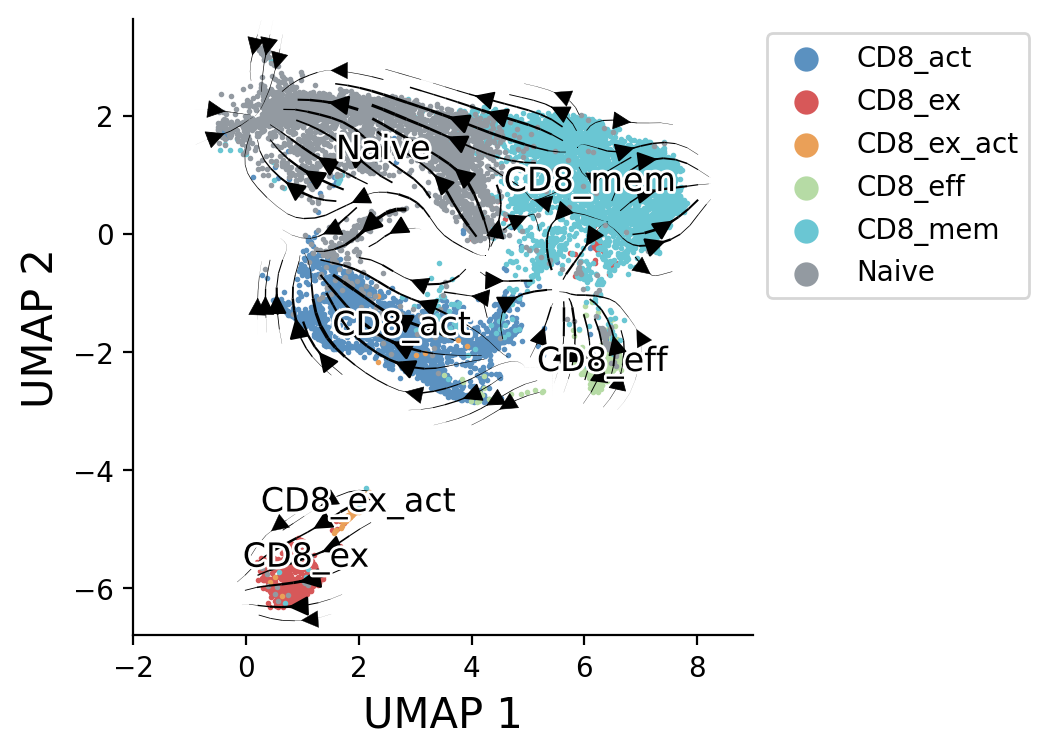

In [393]:
plt.show()

In [134]:
pre_post = pd.DataFrame(metadata.loc[sd.x_normed.index]['treatment'])

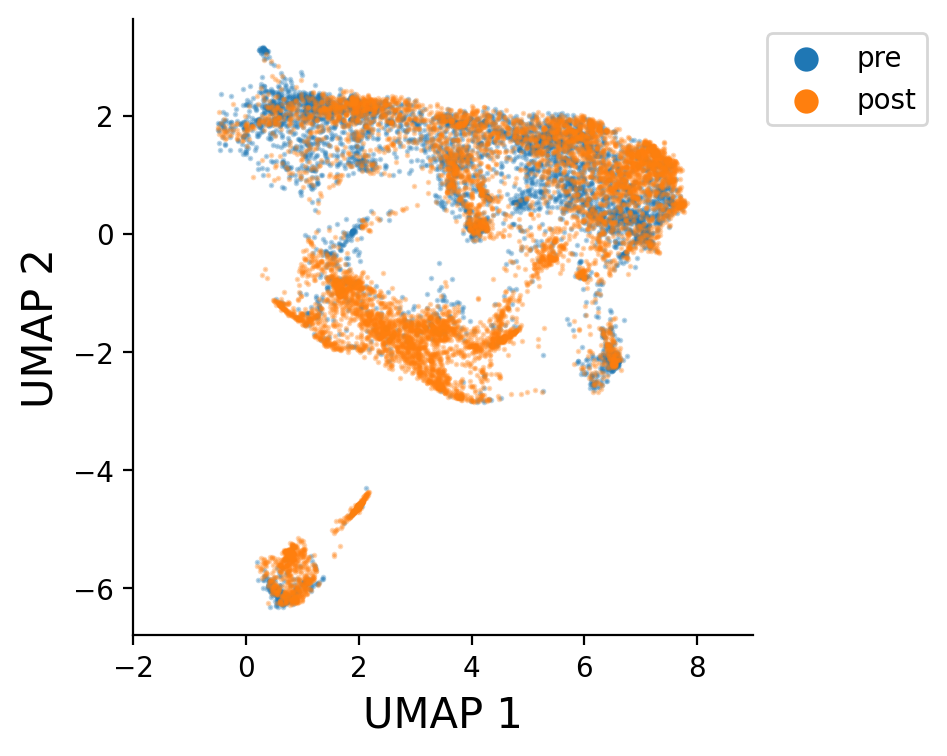

In [276]:
fig, ax = plt.subplots()

ax.scatter(sd.Xdr[np.array(pre_post['treatment'])=='pre'].iloc[:,0], sd.Xdr[pre_post['treatment']=='pre'].iloc[:,1], s=1, label='pre', alpha=0.3)
ax.scatter(sd.Xdr[np.array(pre_post['treatment'])=='post'].iloc[:,0], sd.Xdr[pre_post['treatment']=='post'].iloc[:,1], s=1, label='post', alpha=0.3)

ax.figure.set_size_inches(4, 4)

ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
lgnd = ax.legend(bbox_to_anchor=(1,1), fontsize=10, loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in lgnd.legendHandles:
    i._sizes = [60]
    i._alpha = [1]
ax.set_xlim(-2,9)
# pv.label_name(sd.Xdr.to_numpy(), list(map(lambda x: name_map1[x], sd.cell_states)), ax, fontsize=15)

plt.savefig('../figures/tcr_prepost.pdf')
plt.show()

In [122]:
pv.calc_phylo_pseudotime(sd, r_sample=0.05, n_neighbors=100)

  0%|          | 0/638 [00:00<?, ?it/s]

In [500]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots()

scatter=ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=sd.phylo_pseudotime, s=1, cmap='plasma')
ax.figure.set_size_inches(4, 4)

ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# ax.legend(bbox_to_anchor=(1,1), fontsize=10, loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Patient 5')
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# ax.set_xlim(-2.5, 14)
ax.set_xlim(-2,9)

(-2.0, 9.0)

In [ ]:
pre_post['PhyloVelo pseudotime'] = sd.phylo_pseudotime

(-0.05, 1.15)

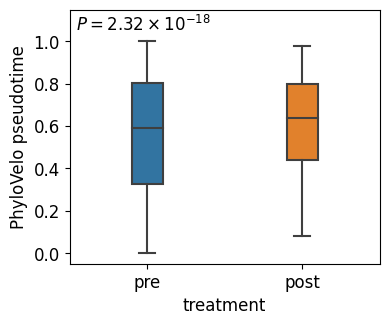

In [160]:
fig, ax = plt.subplots(figsize=(4,3.3))
sns.boxplot(data=pre_post, x='treatment', y='PhyloVelo pseudotime', width=0.2, ax=ax)
ax.text(-0.46, 1.05, r'$P=2.32\times10^{-18}$')
ax.set_ylim(-0.05, 1.15)

In [138]:
pre_pt = pre_post[pre_post['treatment']=='pre']['PhyloVelo pseudotime']
post_pt = pre_post[pre_post['treatment']=='post']['PhyloVelo pseudotime']

In [172]:
import dynamo as dyn

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/wangkun/miniconda3/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [173]:
adata = ad.AnnData(sd.x_normed)
adata.obs['cell_states'] = sd.cell_states
adata.obsm['X_umap'] = sd.Xdr.to_numpy()

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


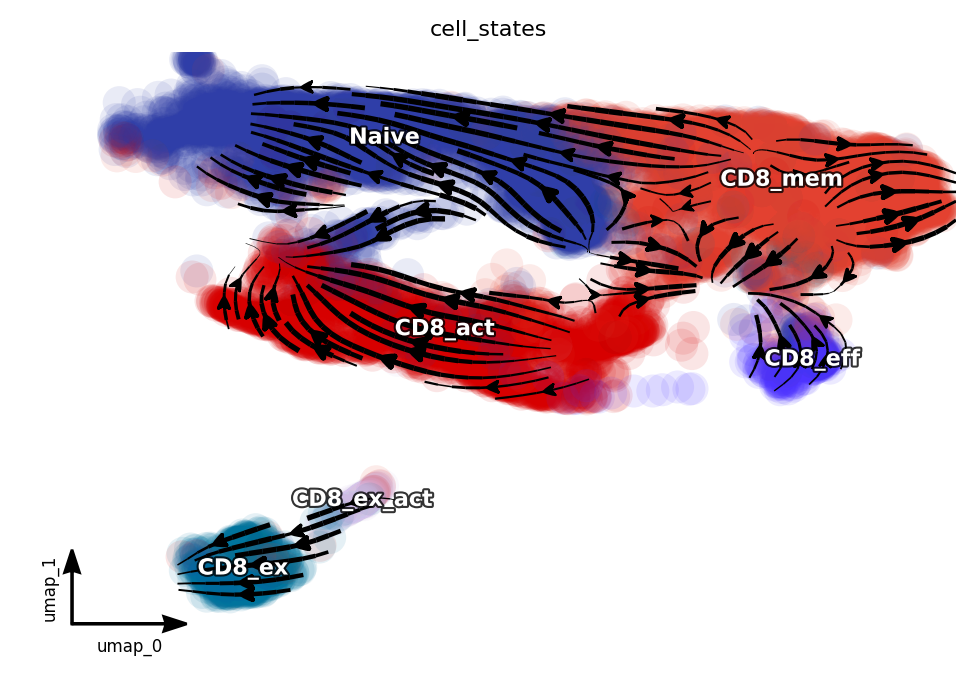

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [2.4855s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] in progress: 100.00

Calculating 2-D curl: 100%|██████████| 12788/12788 [00:00<00:00, 18882.61it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 13/13 [00:00<00:00, 22.16it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.


|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [120.3110s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [115.4325s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f32fccab520>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f32fcb21df0>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edge

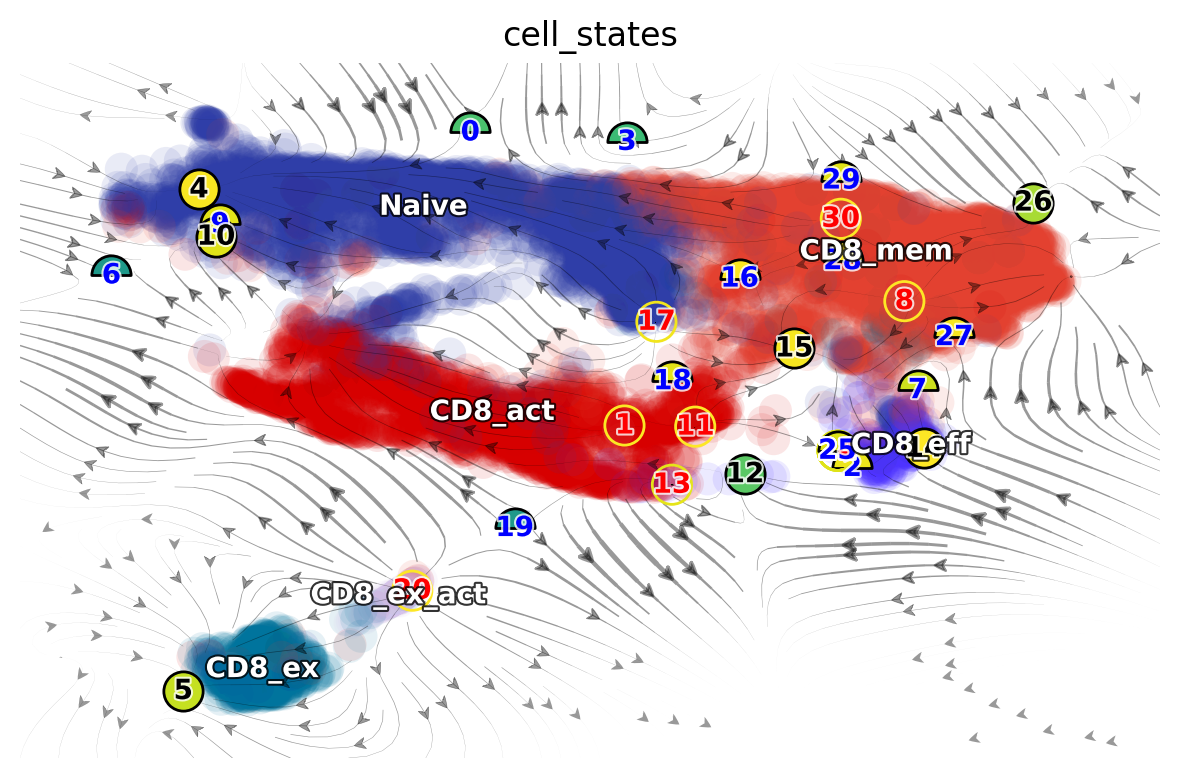

In [174]:
adata.obsm['velocity_umap'] = sd.velocity_embeded
dyn.pl.streamline_plot(adata, color=['cell_states'], basis='umap', show_legend='on data', show_arrowed_spines=True)
dyn.vf.VectorField(adata, basis='umap', M=1000, pot_curl_div=True)
dyn.vf.topography(adata, basis='umap')
dyn.ext.ddhodge(adata, basis='umap')
dyn.pl.topography(adata,color='cell_states')

In [176]:
dyn.pd.state_graph(adata, group='cell_states', basis='umap', method='vf', approx=False)

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0028s]
|-----> [iterate groups] in progress: 16.6667%

uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 337.92it/s]


|-----> [iterate groups] in progress: 33.3333%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 350.70it/s]


|-----> [iterate groups] in progress: 50.0000%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 303.95it/s]


|-----> [iterate groups] in progress: 66.6667%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 328.31it/s]


|-----> [iterate groups] in progress: 83.3333%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 354.10it/s]


|-----> [iterate groups] in progress: 100.0000%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 329.52it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [5.1346s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0030s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]


AnnData object with n_obs × n_vars = 12788 × 12252
    obs: 'cell_states', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap'
    uns: 'cell_states_colors', 'VecFld_umap', 'cell_states_graph'
    obsm: 'X_umap', 'velocity_umap', 'velocity_umap_SparseVFC', 'X_umap_SparseVFC'

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

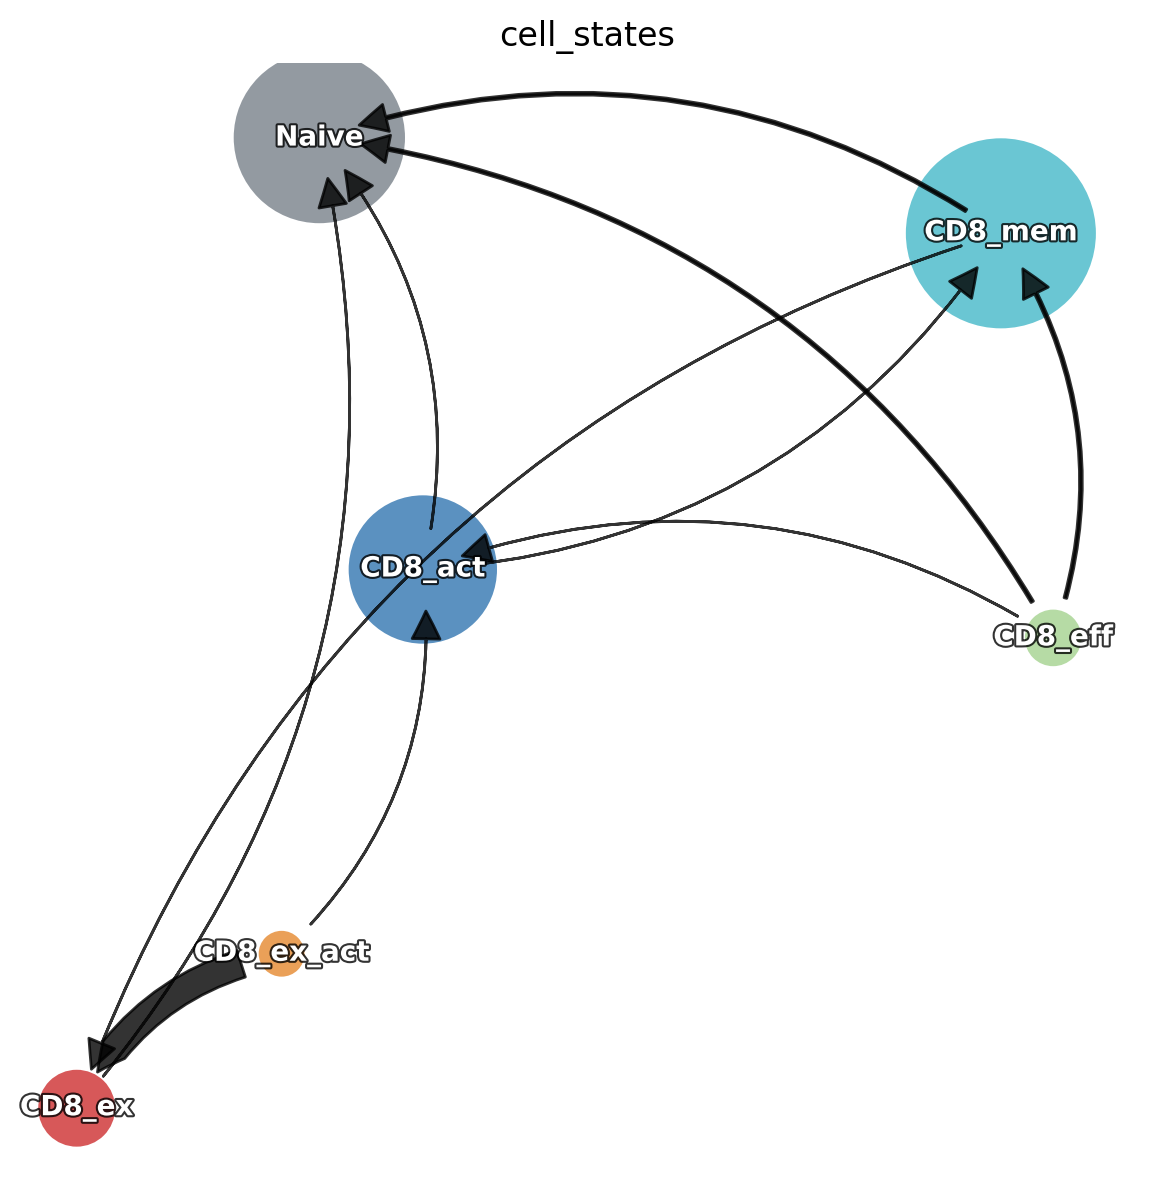

In [184]:
ax = dyn.pl.state_graph(adata,
                        color=['cell_states'],
                        group='cell_states',
                        basis='umap',
                        show_legend='on data',
                        method='vf',
                        figsize=(4,4),
                        edge_scale=0.8,
                        color_key=color_map,
                        save_show_or_return='show',  
                        stack_colors_title =None,
                        graph_alpha=0.8*np.ones((12,12))
                  )
# ax=ax[0]
# ax.set_ylim(-6.3, 10)
# ax.set_xlim(-10, 5)

In [178]:
transition_mat = adata.uns['cell_states_graph']['group_graph']
transition_groups = adata.uns['cell_states_graph']['group_names']
transition_mat = pd.DataFrame(transition_mat, index=transition_groups, columns=transition_groups)

In [179]:
order = ['Naive', 'CD8_act', 'CD8_ex', 'CD8_ex_act', 'CD8_mem', 'CD8_eff']
sel_transitmat = transition_mat[order].loc[order]
sel_transitmat = np.round(sel_transitmat,2)
sel_transitmat = sel_transitmat / sel_transitmat.sum(axis=1)

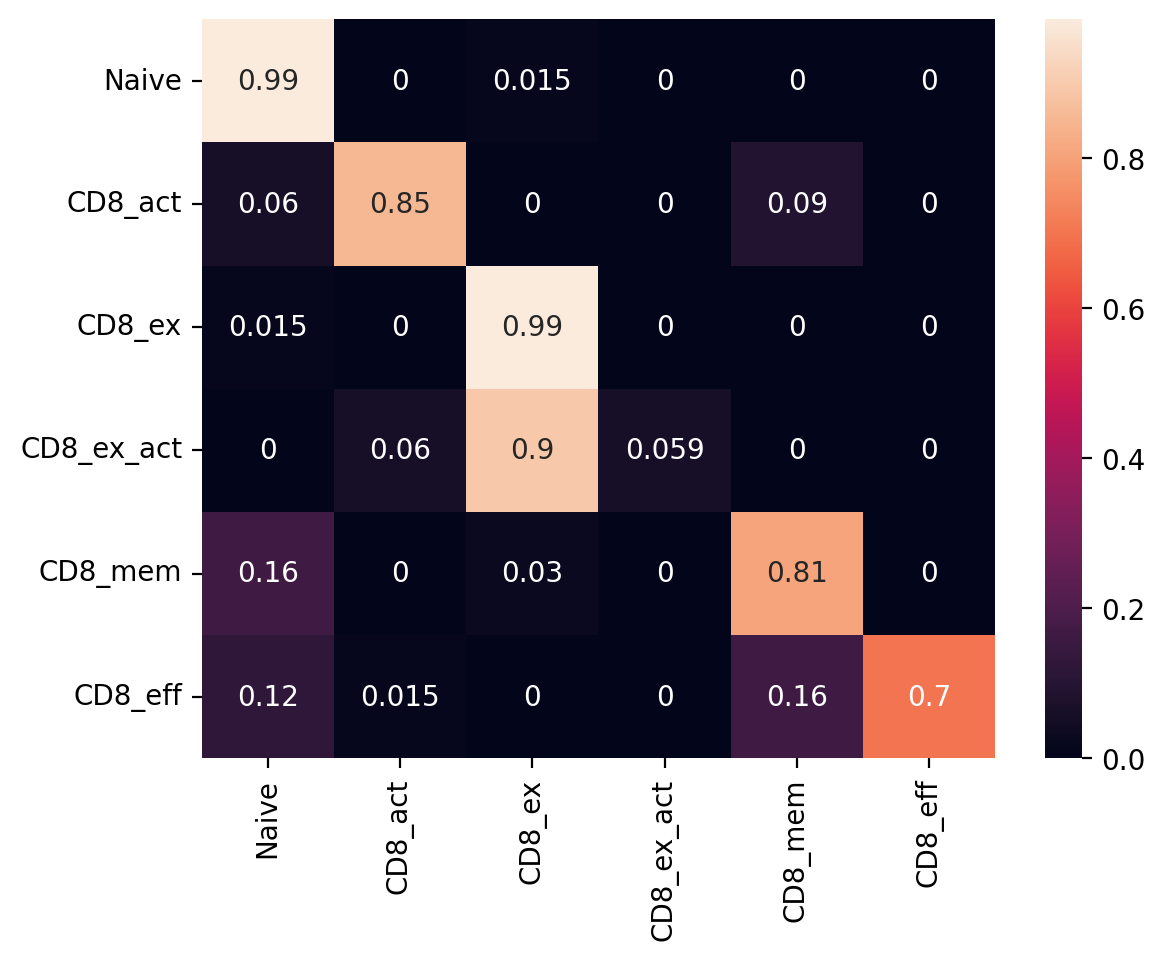

In [180]:
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(sel_transitmat, annot=True, ax=ax)
plt.show()

In [215]:
adata_pre = adata[pre_post[pre_post['treatment']=='pre'].index]
adata_post = adata[pre_post[pre_post['treatment']=='post'].index]

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


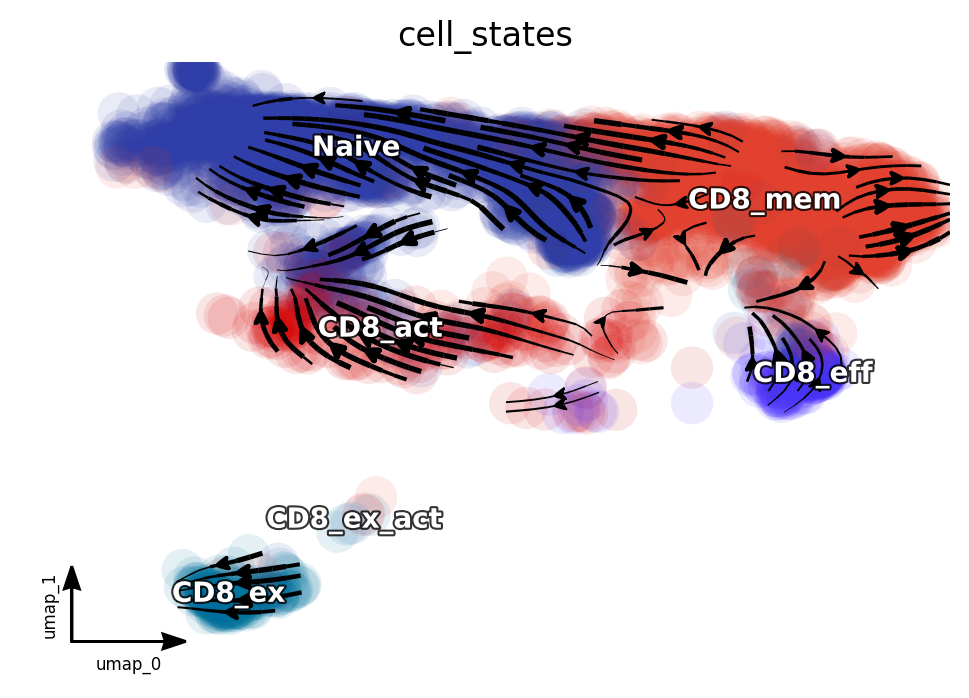

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [1.1594s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [93.5364s]
|-----> Computing curl...


Calculating 2-D curl: 100%|██████████| 4715/4715 [00:00<00:00, 16498.32it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 5/5 [00:00<00:00, 23.27it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.


|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [95.5654s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


|-----> fetch computation results from adata.obsp[umap_ddhodge]...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [93.2366s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f33371ecf70>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f33371f01f0>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edge

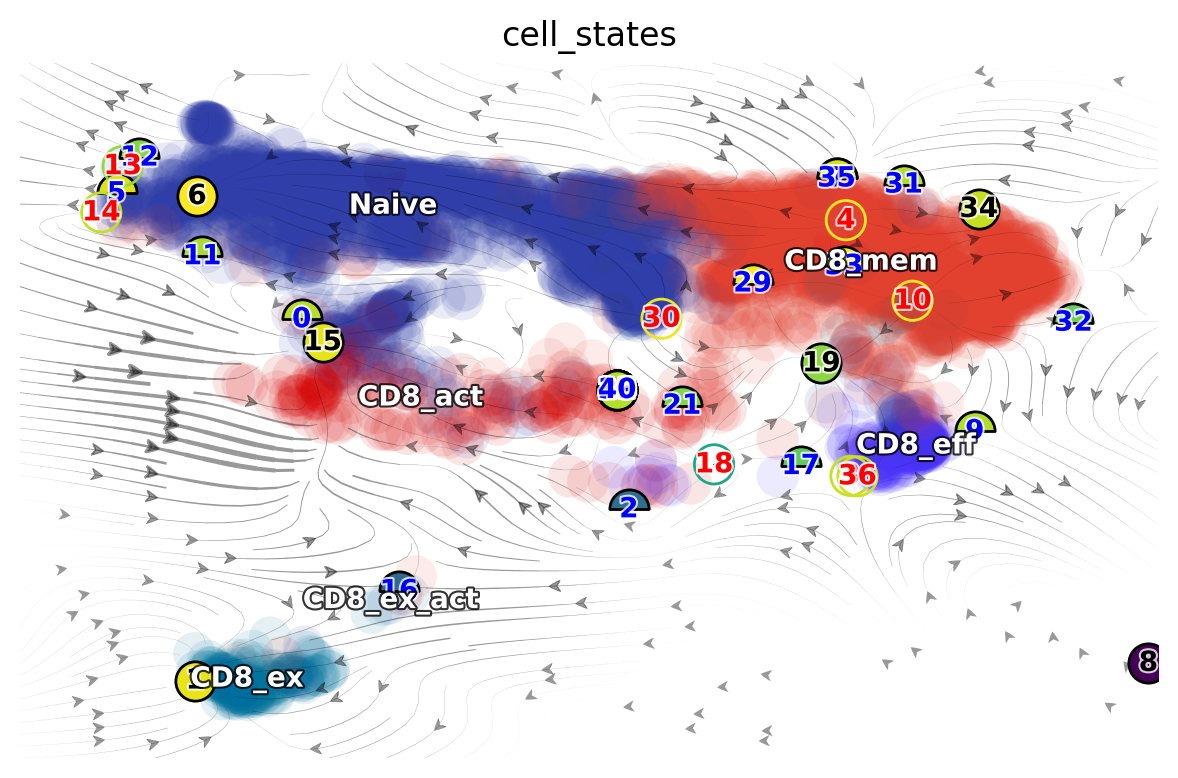

In [216]:
dyn.pl.streamline_plot(adata_pre, color=['cell_states'], basis='umap', show_legend='on data', show_arrowed_spines=True)
dyn.vf.VectorField(adata_pre, basis='umap', M=1000, pot_curl_div=True)
dyn.vf.topography(adata_pre, basis='umap')
dyn.ext.ddhodge(adata_pre, basis='umap')
dyn.pl.topography(adata_pre,color='cell_states')

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


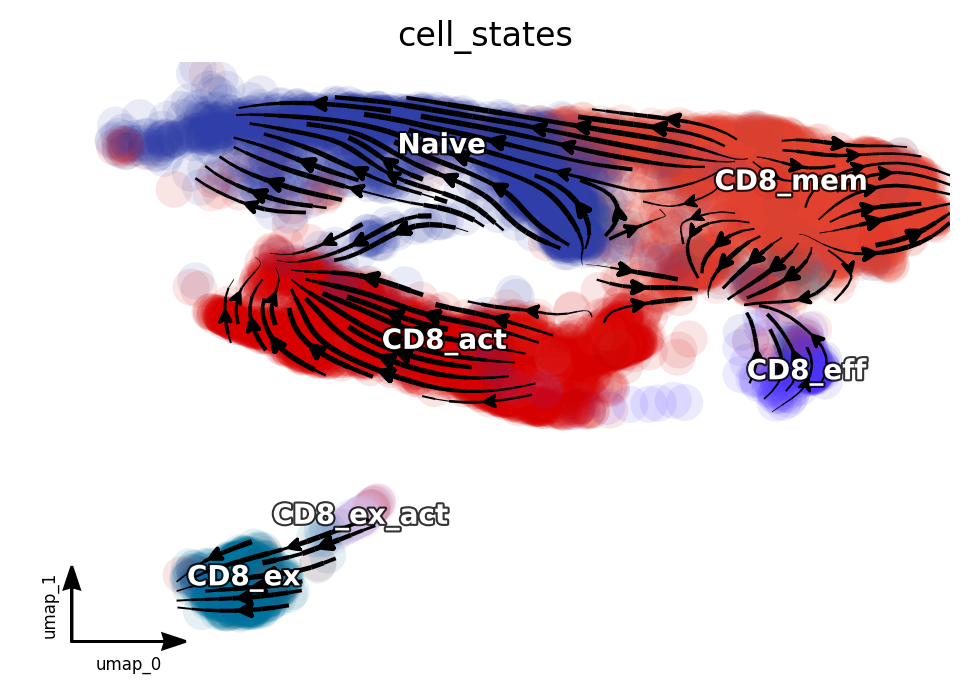

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [3.0952s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] in progress: 100.00

Calculating 2-D curl: 100%|██████████| 8073/8073 [00:00<00:00, 18443.76it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 9/9 [00:00<00:00, 24.16it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.


|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [120.0906s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [115.3109s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f32fc9fa100>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f32fc9fa820>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edge

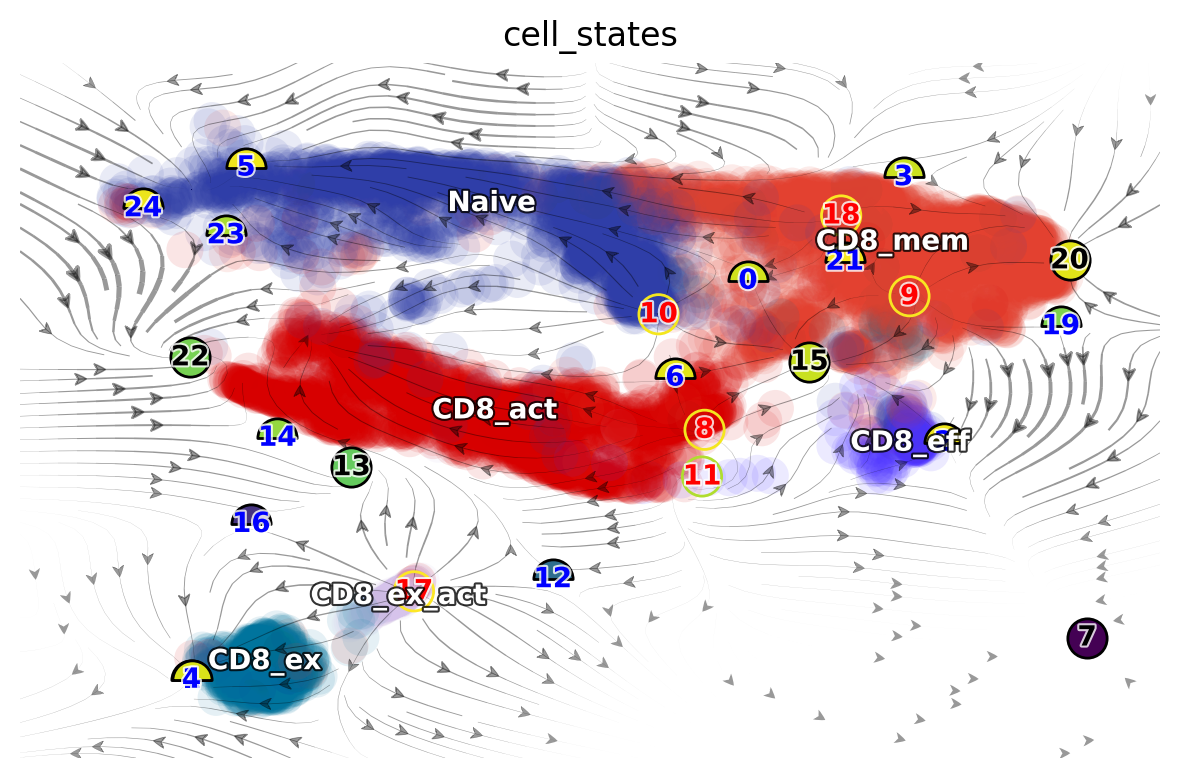

In [217]:
dyn.pl.streamline_plot(adata_post, color=['cell_states'], basis='umap', show_legend='on data', show_arrowed_spines=True)
dyn.vf.VectorField(adata_post, basis='umap', M=1000, pot_curl_div=True)
dyn.vf.topography(adata_post, basis='umap')
dyn.ext.ddhodge(adata_post, basis='umap')
dyn.pl.topography(adata_post,color='cell_states')

In [219]:
dyn.pd.state_graph(adata_pre, group='cell_states', basis='umap', method='vf', approx=False)

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0013s]
|-----> [iterate groups] in progress: 16.6667%

uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 338.11it/s]


|-----> [iterate groups] in progress: 33.3333%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 351.13it/s]


|-----> [iterate groups] in progress: 50.0000%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 362.25it/s]


|-----> [iterate groups] in progress: 66.6667%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 359.00it/s]


|-----> [iterate groups] in progress: 83.3333%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 366.67it/s]


|-----> [iterate groups] in progress: 100.0000%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/4 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 4/4 [00:00<00:00, 285.07it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [3.8266s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0020s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]


AnnData object with n_obs × n_vars = 4715 × 12252
    obs: 'cell_states', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'treatment'
    uns: 'cell_states_colors', 'VecFld_umap', 'cell_states_graph', 'treatment_graph', 'treatment_colors'
    obsm: 'X_umap', 'velocity_umap', 'velocity_umap_SparseVFC', 'X_umap_SparseVFC'
    obsp: 'umap_ddhodge'

In [220]:
dyn.pd.state_graph(adata_post, group='cell_states', basis='umap', method='vf', approx=False)

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0017s]
|-----> [iterate groups] in progress: 16.6667%

uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 357.10it/s]


|-----> [iterate groups] in progress: 33.3333%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 331.58it/s]


|-----> [iterate groups] in progress: 50.0000%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 342.65it/s]


|-----> [iterate groups] in progress: 66.6667%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 355.11it/s]


|-----> [iterate groups] in progress: 83.3333%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:   0%|          | 0/100 [00:00<?, ?it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 360.56it/s]


|-----> [iterate groups] in progress: 100.0000%

/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]
uniformly sampling points along a trajectory:  34%|███▍      | 34/100 [00:00<00:00, 332.92it/s]/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/vectorfield/topography.py:218: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(xFFt1 - xFFt2) / len(xFFt1)
uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 331.67it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [4.9052s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0028s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/prediction/state_graph.py:326: RuntimeWarning: invalid value encountered in true_divide
  grp_avg_time[i, :] /= grp_graph[i, :]


AnnData object with n_obs × n_vars = 8073 × 12252
    obs: 'cell_states', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'treatment'
    uns: 'cell_states_colors', 'VecFld_umap', 'cell_states_graph', 'treatment_graph', 'treatment_colors'
    obsm: 'X_umap', 'velocity_umap', 'velocity_umap_SparseVFC', 'X_umap_SparseVFC'

In [322]:
adata_pre.obs['cell_states_full'] = list(map(lambda x: name_map1[x], adata_pre.obs['cell_states']))

In [323]:
adata_pre.uns['cell_states_full_graph'] = adata_pre.uns['cell_states_graph']

In [325]:
color_map={'CD8_act': '#5b91c0',
 'CD8_eff': '#b6dba5',
 'CD8_ex': '#d75859',
 'CD8_ex_act': '#eaa058',
 'CD8_mem': '#6ac6d3',
 'Naive': '#939aa1'}

In [326]:
name_map={'CD8_act': 'Activated T cells',
 'CD8_eff': 'Effector memory CD8$^+$T cells',
 'CD8_ex': 'Exhausted CD8$^+$T cells',
 'CD8_ex_act': 'Activated/exhausted CD8$^+$T cells',
 'CD8_mem': 'Memory CD8$^+$T cells',
 'Naive': 'Naive T cells'}

In [317]:
color_map_full = dict()
for i in color_map:
    color_map_full[name_map[i]] = color_map[i]

In [318]:
color_map_full

{'Activated T cells': '#5b91c0',
 'Effector memory CD8$^+$T cells': '#b6dba5',
 'Exhausted CD8$^+$T cells': '#d75859',
 'Activated/exhausted CD8$^+$T': '#eaa058',
 'Memory CD8$^+$T cells': '#6ac6d3',
 'Naive T cells': '#939aa1'}

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

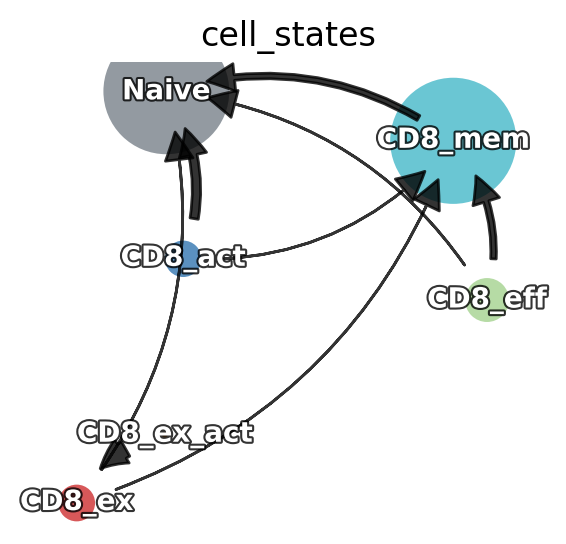

In [331]:
ax = dyn.pl.state_graph(adata_pre,
                        color=['cell_states'],
                        group='cell_states',
                        basis='umap',
                        show_legend='on data',
                        method='vf',
                        figsize=(3,3),
                        edge_scale=1.2,
                        color_key=color_map,
                        show_legends =False,
                        save_show_or_return='return',  
                        stack_colors_title =None,
                        graph_alpha=0.8*np.ones((12,12))
                  )
# ax=ax[0]
# ax.set_ylim(-6.3, 10)
# ax.set_xlim(-10, 5)
plt.savefig('../figures/tcr_pre_state.pdf')
plt.show()

In [298]:
adata_post

AnnData object with n_obs × n_vars = 8073 × 12252
    obs: 'cell_states', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'treatment'
    uns: 'cell_states_colors', 'VecFld_umap', 'cell_states_graph', 'treatment_graph', 'treatment_colors'
    obsm: 'X_umap', 'velocity_umap', 'velocity_umap_SparseVFC', 'X_umap_SparseVFC'

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

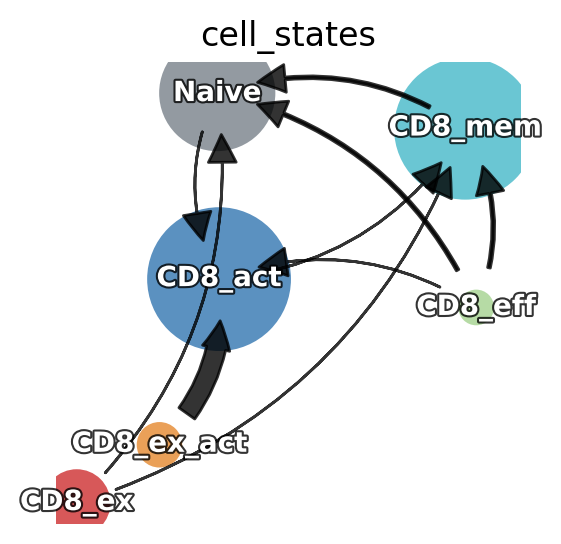

In [286]:
ax = dyn.pl.state_graph(adata_post,
                        color=['cell_states'],
                        group='cell_states',
                        basis='umap',
                        show_legend='on data',
                        method='vf',
                        figsize=(3,3),
                        edge_scale=1.2,
                        color_key=color_map,
                        save_show_or_return='return',  
                        stack_colors_title =None,
                        graph_alpha=0.8*np.ones((12,12))
                  )
# ax=ax[0]
# ax.set_ylim(-6.3, 10)
# ax.set_xlim(-10, 5)
plt.savefig('../figures/tcr_post_state.pdf')
plt.show()

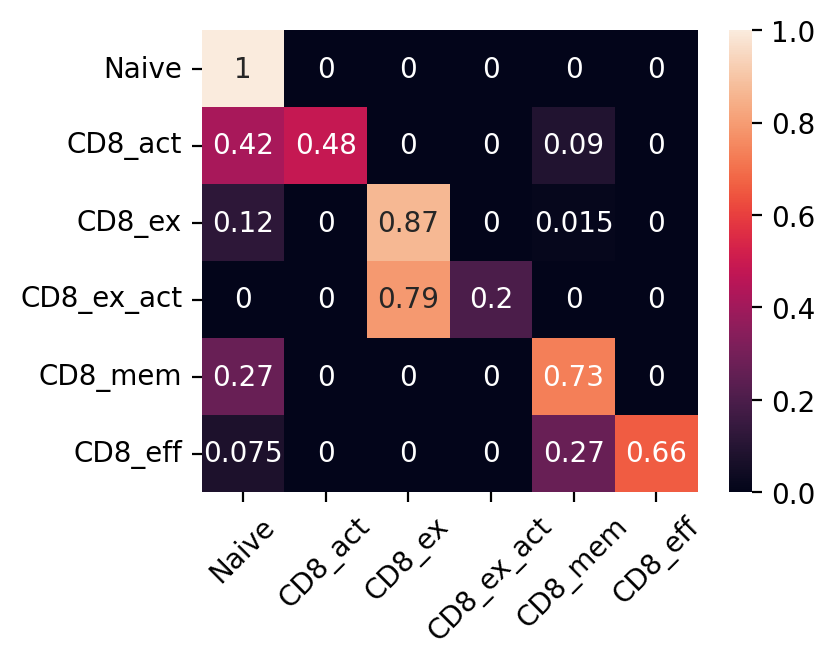

In [394]:
transition_mat = adata_pre.uns['cell_states_graph']['group_graph']
transition_groups = adata_pre.uns['cell_states_graph']['group_names']
transition_mat = pd.DataFrame(transition_mat, index=transition_groups, columns=transition_groups)
order = ['Naive', 'CD8_act', 'CD8_ex', 'CD8_ex_act', 'CD8_mem', 'CD8_eff']
sel_transitmat = transition_mat[order].loc[order]
sel_transitmat = np.round(sel_transitmat,2)
sel_transitmat = sel_transitmat / sel_transitmat.sum(axis=1)
# sel_transitmat.index = list(map(lambda x: name_map1[x], sel_transitmat.index))
# sel_transitmat.columns = sel_transitmat.index
import seaborn as sns
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(sel_transitmat, annot=True, ax=ax)
ax.set_xticklabels(sel_transitmat.columns, rotation=45)
plt.savefig('../figures/tcr_pre_mat.pdf')
plt.show()

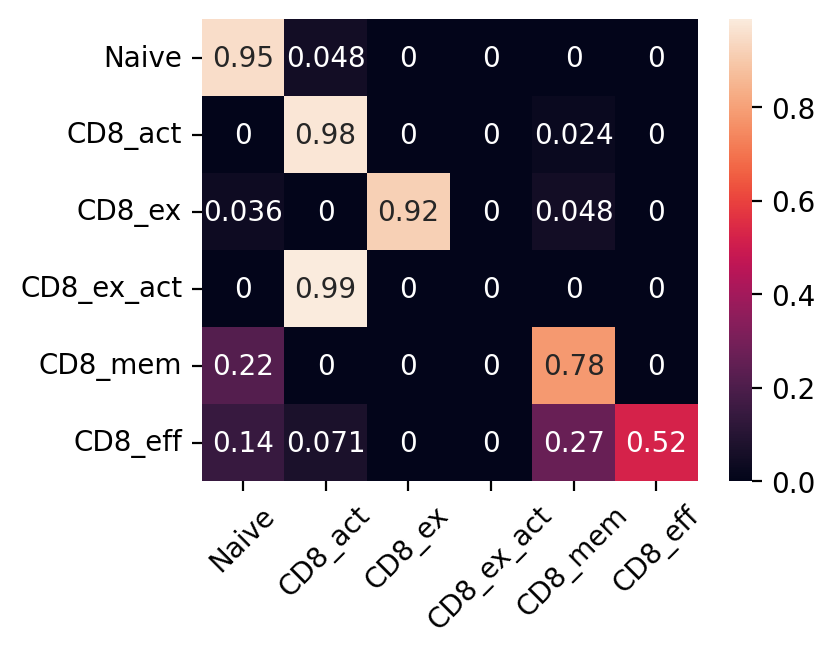

In [395]:
transition_mat = adata_post.uns['cell_states_graph']['group_graph']
transition_groups = adata_post.uns['cell_states_graph']['group_names']
transition_mat = pd.DataFrame(transition_mat, index=transition_groups, columns=transition_groups)
order = ['Naive', 'CD8_act', 'CD8_ex', 'CD8_ex_act', 'CD8_mem', 'CD8_eff']
sel_transitmat = transition_mat[order].loc[order]
sel_transitmat = np.round(sel_transitmat,2)
sel_transitmat = sel_transitmat / sel_transitmat.sum(axis=1)
# sel_transitmat.index = list(map(lambda x: name_map1[x], sel_transitmat.index))
# sel_transitmat.columns = sel_transitmat.index
import seaborn as sns
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(sel_transitmat, annot=True, ax=ax)
ax.set_xticklabels(sel_transitmat.columns, rotation=45)
plt.savefig('../figures/tcr_post_mat.pdf')
plt.show()

In [372]:
clonesize = metadata.loc[sd.x_normed.index].clonesizeInCase.to_numpy()

In [374]:
np.random.shuffle(clonesize)

In [375]:
from copy import deepcopy

In [376]:
sd_permutation = deepcopy(sd)

In [377]:
pv.velocity_inference(sd_permutation, np.round(np.log(clonesize)), cutoff=0.97, target='x_normed')

  0%|          | 0/12252 [00:00<?, ?it/s]

/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [383]:
v_megs = pd.DataFrame(data=sd_permutation.velocity, index=sd_permutation.x_normed.columns, columns=['velocity']).loc[sd_permutation.megs]
v_megs['p_value']=sd_permutation.pvals.T
v_megs['q_value']=sd_permutation.qvals.T
v_megs.to_csv('../megs/tcr_permutation.csv')

In [398]:
v_megs = pd.read_csv('../megs/tcr_009.csv', index_col=0)

In [406]:
rpgs = []
for i in v_megs.index:
    if i[:3] in ['RPS', 'RPL']:
        rpgs.append(i)

In [411]:
sc.tl.score_genes(adata, rpgs)

/home/wangkun/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [498]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots()

scatter=ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=sd.phylo_pseudotime, s=1, cmap='plasma')
ax.figure.set_size_inches(6, 6)

# ax.legend(bbox_to_anchor=(1,1), fontsize=10, loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('Patient 5')
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# ax.set_xlim(-2.5, 14)
ax.set_xlim(-2,9)

(-2.0, 9.0)

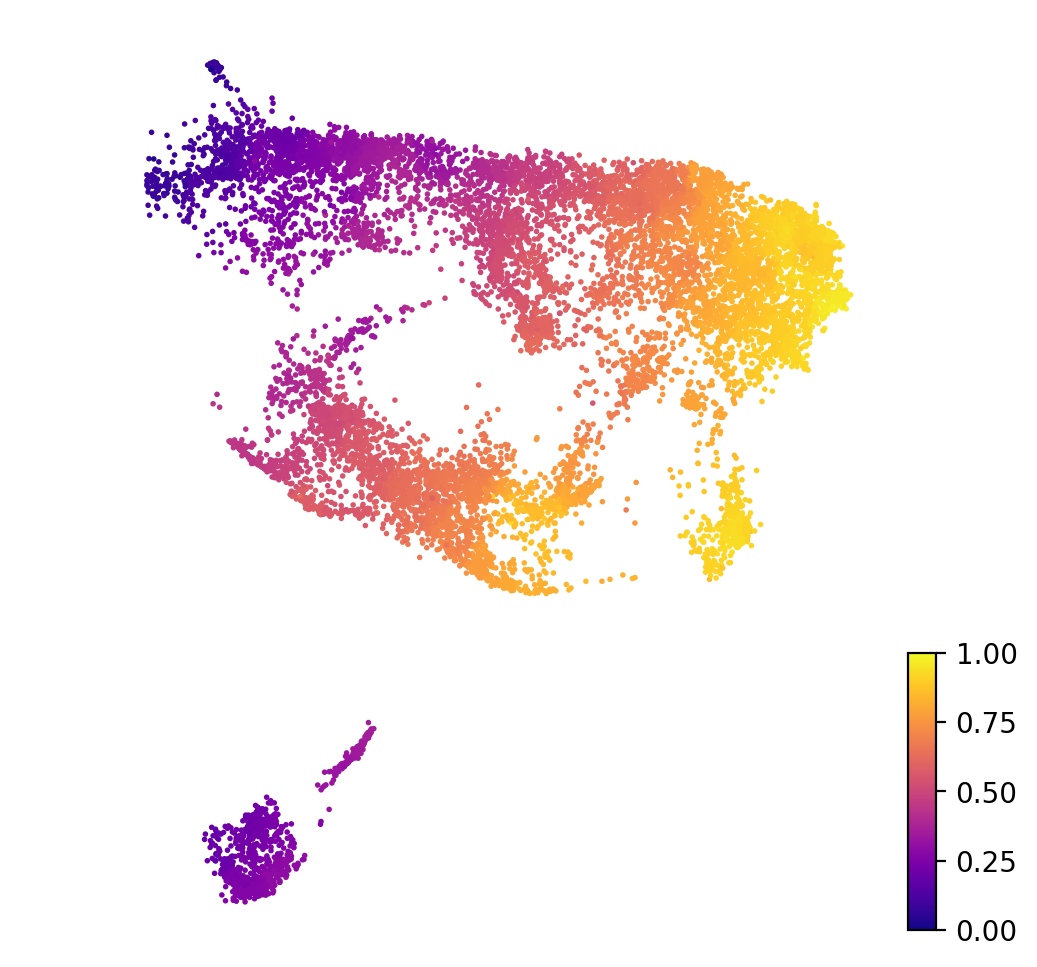

In [499]:
plt.show()

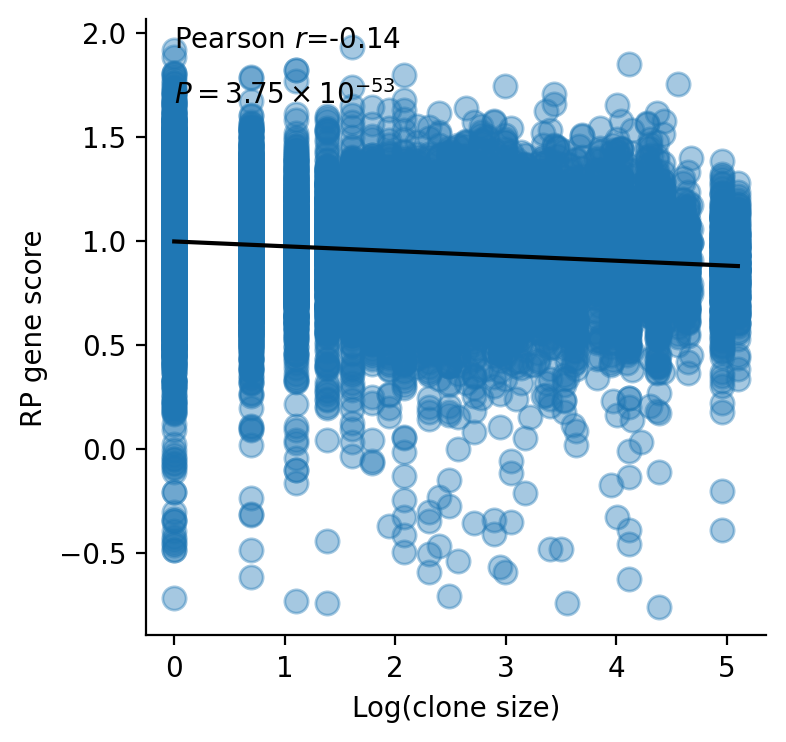

In [475]:
fig, ax = plt.subplots(figsize=(4,4))
pv.corr_plot(np.log(clonesize), adata.obs['score'], ax)
ax.set_xlabel('Log(clone size)')
ax.set_ylabel('RP gene score')
plt.show()

In [456]:
from sklearn.preprocessing import scale
import seaborn as sns
from scipy.stats import spearmanr
gene_vel_map = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns)

genes1 = gene_vel_map.index[(gene_vel_map>0).to_numpy().flatten()]
genes2 = gene_vel_map.index[(gene_vel_map<0).to_numpy().flatten()]
genes1 = genes1[np.argsort(scale(sd.x_normed[genes1], axis=0).sum(0))]
genes2 = genes2[np.argsort(scale(sd.x_normed[genes2], axis=0).sum(0))]
genes1 = genes1[::-1]

genetraj1 = []
for i in genes1:
    genetraj1.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj1 = np.array(genetraj1)
# genetraj1 = np.log(1+genetraj1)
# genetraj1 = (genetraj1.T / np.max(genetraj1, axis=1)).T

genetraj2 = []
for i in genes2:
    genetraj2.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj2 = np.array(genetraj2)
# genetraj2 = np.log(1+genetraj2)
# genetraj2 = (genetraj2.T / np.max(genetraj2, axis=1)).T

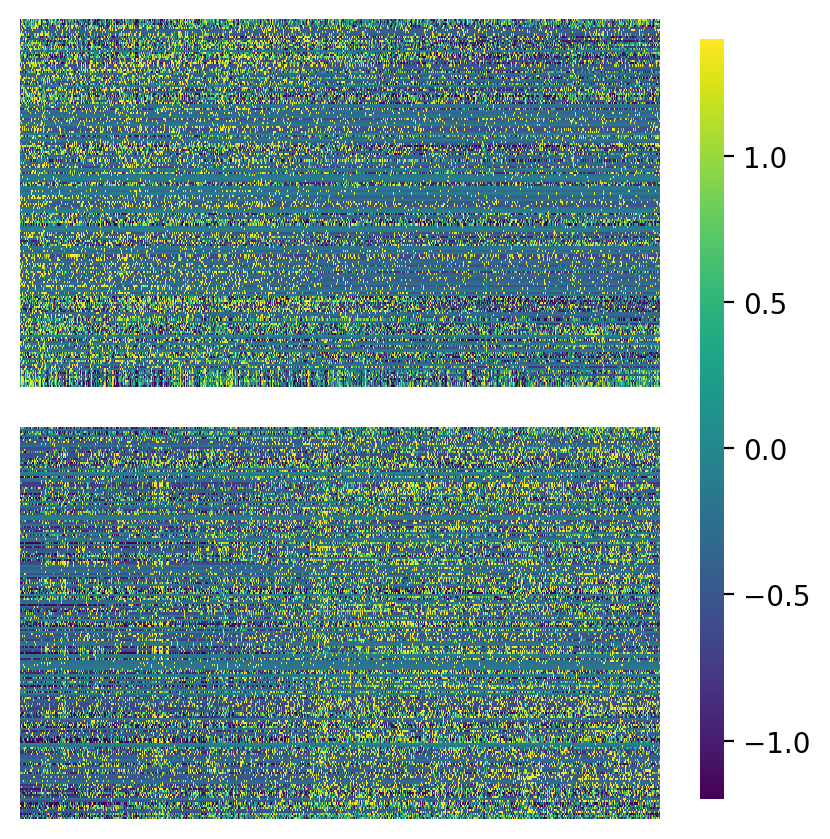

In [466]:
fig = plt.figure(figsize=(4,4))
h1 = len(genes1)/(len(genes1)+len(genes2))
h2 = len(genes2)/(len(genes1)+len(genes2))
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

ax1 = sns.heatmap(genetraj1, cmap='viridis', ax=ax1, cbar_ax=ax3,vmax=1.4, vmin=-1.2, xticklabels=False, yticklabels='')
ax2 = sns.heatmap(genetraj2[::-1], cmap='viridis', ax=ax2, cbar=False,vmax=1.4, vmin=-1.2, xticklabels=False, yticklabels='')

plt.show()

In [ ]:
vels = pd.read_csv('../megs/tcr_009.csv', index_col=0)

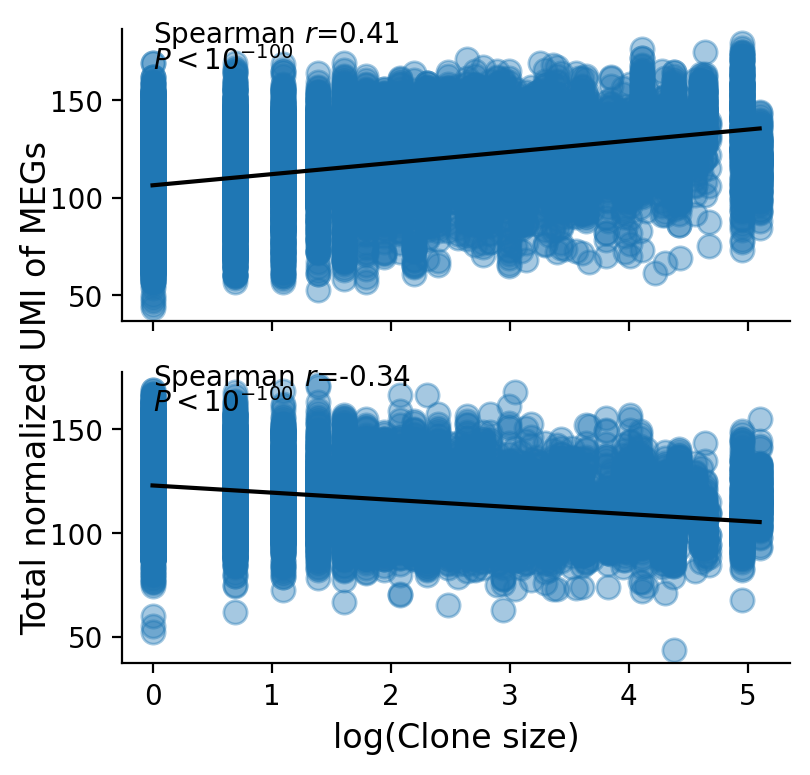

In [470]:

from scipy.stats import spearmanr

x = np.log(clonesize)
y = sd.x_normed[genes1].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
pv.corr_plot(x,y, ax[0], stats='spearman')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)



y = sd.x_normed[genes2].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b


pv.corr_plot(x,y, ax[1], stats='spearman')

fig.text(0, 0.5, 'Total normalized UMI of MEGs', va='center', rotation='vertical',fontsize=12)
ax[1].set_xlabel('log(Clone size)', fontsize=12)
plt.tight_layout()
plt.show()